# <center>Instituto Tecnológico de Estudios Superiores de Occidente</center>



<img style="float: center" src="logo-ITESO-png.png" width="350px" height="125px"/>




#### <center>"Simulación Matemática"</center>


### <center>SIMULACIÓN DE UN PORTAFOLIO DE INVERSIÓN</center>

.



**<center>Profesor: Gabriel Alejando Morales Ruiz</center>**

.



**<center>Leonardo Rodríguez Hernández - 741983</center>**



**<center>Valenzuela Lafarga Mariana - 749770</center>**



**<center>Nancy Woolrich Sorroza - 741983</center>**



.


**<center>22 de abril 2024.</center>**

## <center> Construcción de un portafolio de inversión con programación lineal</center>

### Introducción
    
  
    

### Objetivos

#### 1.1 Objetivo general.

Pronosticar un portaforlio de inversión a un año.

#### 1.2 Objetivos específicos
- Calcular la media y desviación estándar de los rendimientos diarios de las acciones de cada empresa para evaluar su distribución y realizar el pronóstico

- Utilizar el método de aproximación de Montecarlo para simular múltiples escenarios de rendimiento del portafolio de inversión en el próximo año.
- Generar visualizaciones claras y concisas de los resultados del proyecto, incluidas gráficas de desempeño del portafolio y distribuciones de rendimientos simulados.


### Modelo del problema.

Para generar el modelo que pronostique los rendimientos a 1 año se utilizarán los datos diarios del 14 de abril de 2022 a 2023 para poder realizar la comparación con el año 2024 y determinar si el modelo planteado es válido, los datos son sacados de Yahoo finance.

Las acciones con las que se trabajará en el portafolio son:

>- **AAPL:** Apple Inc. diseña, fabrica y comercializa teléfonos inteligentes, computadoras personales, tabletas, dispositivos portátiles y accesorios en todo el mundo.Es la empresa de tecnología más grande del mundo.

>- **AZO:** AutoZone, Inc. vende y distribuye repuestos y accesorios automotrices en Estados Unidos, México y Brasil. La empresa ofrece diversos productos para automóviles, vehículos utilitarios deportivos, camionetas y camiones ligeros.


>- **VRTX:** Ertex Pharmaceuticals Incorporated, una empresa de biotecnología, se dedica al desarrollo y comercialización de terapias para el tratamiento de la fibrosis quística (FQ).


>- **OXY:** Occidental Petroleum Corporation, junto con sus subsidiarias, se dedica a la adquisición, exploración y desarrollo de propiedades de petróleo y gas en los Estados Unidos, Medio Oriente y el norte de África.


>- **WMT:** Walmart Inc. se dedica a la operación de ventas al por menor, al por mayor, otras unidades y comercio electrónico en todo el mundo. La empresa opera a través de tres segmentos: Walmart U.S., Walmart International y Sam's Club.

Se decidieron escoger acciones que fueran medianamente estables con volatilidades no tan altas para que el modelo tenga un menor grado de error. 


In [7]:
import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
%matplotlib inline
yf.pdr_override()

In [18]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers,
                   start_date=None,
                   end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date
    )
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [101]:
tickers = ["AAPL", "AZO", "VRTX", "OXY", "WMT"]
start_date = "2023-04-14"
end_date= "2024-04-14"
closes = get_adj_closes(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date
)
closes.head()

[*********************100%%**********************]  5 of 5 completed


,AAPL,AZO,OXY,VRTX,WMT
Date,,,,,
2023-04-14,164.332840,2638.320068,63.675758,333.519989,48.783424
2023-04-17,164.352737,2665.409912,62.154961,327.739990,49.125118
2023-04-18,165.586151,2681.649902,62.214218,325.149994,49.233536
2023-04-19,166.740005,2663.159912,61.690826,328.450012,49.286106
2023-04-20,165.765198,2701.840088,61.256313,329.149994,49.601521


.

- **Modelo**

El siguente paso es obtener el rendimiento diario, para ello se va a observar la distribución de los rendimientos y así comprobar que se asemejen a una distribucion normal.

.

In [102]:
ret = closes.pct_change().dropna()
ret.head()

,AAPL,AZO,OXY,VRTX,WMT
Date,,,,,
2023-04-17,0.000121,0.010268,-0.023883,-0.017330,0.007004
2023-04-18,0.007505,0.006093,0.000953,-0.007903,0.002207
2023-04-19,0.006968,-0.006895,-0.008413,0.010149,0.001068
2023-04-20,-0.005846,0.014524,-0.007043,0.002131,0.006400
2023-04-21,-0.009781,-0.007562,-0.002579,0.005894,0.005034


En la siguiente gráfica podemos ver que las distribuciones de los rendimientos se asemejan a una normal

array([[<Axes: title={'center': 'AAPL'}>,
        <Axes: title={'center': 'AZO'}>],
       [<Axes: title={'center': 'OXY'}>,
        <Axes: title={'center': 'VRTX'}>],
       [<Axes: title={'center': 'WMT'}>, <Axes: >]], dtype=object)

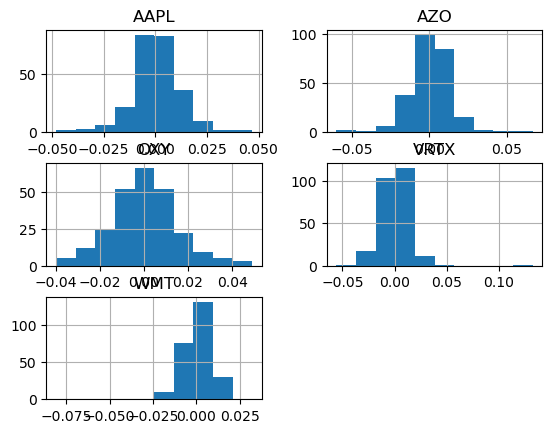

In [103]:
ret.hist()


Ahora se van a obtener los datos de media y desviación estándar para cada uno de estos activos y así tener los parámetros de las distribuciones.

In [104]:
summary_daily = pd.DataFrame({
    "mean": ret.mean(),
    "vol": ret.std()
}).T
summary_daily

,AAPL,AZO,OXY,VRTX,WMT
mean,0.000362,0.000556,0.000429,0.000803,0.000883
vol,0.012263,0.013593,0.014709,0.015070,0.009479


Una vez obtenidos los parámetros de media y desviación de cada uno de los activos se va a realizar la simulación a 1 año con la siguiente función.

In [105]:
def simR(media,std,start,dias,N):
    sim_R= np.random.normal(media, std,size=(dias,N))+1
    fechas= pd.date_range(start,periods=dias)
    return pd.DataFrame(sim_R,index=fechas)

- **Explicación y limitaciones**

El modelo planteado anteriormente pretende obtener el rendimiento pronosticado del portafolio planteado a 1 año, esto se obtiene mediamente las simulaciones de 365 dias según la media y la desviación de cada activo, después se obtiene el precio final y para determinar rendimiento total.

Las limitaciones que presenta este modelo es que los activos pueden no siempre seguir la misma tendencia, y si son activos muy volátiles su media y su desviación estandar cambia drásticamente de un periodo a otro, por lo que puede no ser un modelo tan certero para todo tipo de activos.

### Solución del modelo



Primeramente hacemos una variable para cada desviación estándar y media de cada empresa.

In [106]:
aaplmean = ret["AAPL"].mean()
aaplstd = ret["AAPL"].std()
wmtmean = ret["WMT"].mean()
wmtstd = ret["WMT"].std()
azomean = ret["AZO"].mean()
azostd = ret["AZO"].std()
oxymean = ret["OXY"].mean()
oxystd = ret["OXY"].std()
vrtxmean = ret["VRTX"].mean()
vrtxstd = ret["VRTX"].std()


Simulamos para cada Empresa el rendimiento a 1 año:

**APPLE**

In [107]:
#Simulación del rendimiento a 1 año
sim_R_aapl =simR(aaplmean,aaplstd, "2024-04-22", 365, 1000)
sim_R_aapl

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,1.010391,1.002470,1.019527,1.005615,0.996041,1.008906,1.031175,0.995841,1.007172,1.019359,...,1.006340,0.996655,0.981319,1.007730,1.005871,1.000774,0.994925,1.009435,1.005016,0.983820
2024-04-23,0.998584,1.000897,0.992116,1.009464,1.013992,1.004168,0.991510,0.997653,1.006274,0.994749,...,1.007607,1.003288,1.003384,0.993078,0.996045,1.005020,0.993263,1.005444,1.001428,1.003971
2024-04-24,0.997752,1.000285,0.984597,1.012216,0.993308,1.014092,1.004246,0.998197,0.988196,1.001502,...,0.994839,1.006911,0.996953,1.000039,0.995282,1.005504,1.027453,1.008921,1.000548,1.009635
2024-04-25,1.006476,0.998754,1.002929,1.017751,0.993886,0.998157,0.986504,0.987942,0.990316,1.002853,...,1.017656,0.998007,1.011913,0.984509,0.989049,0.999232,0.983321,1.014005,1.025703,0.996169
2024-04-26,0.998996,0.992816,0.985617,1.002176,1.037700,1.005909,0.998882,1.013942,1.005935,1.007105,...,0.979071,1.010894,1.001404,0.996028,0.987935,1.002092,0.988112,1.011646,1.008811,1.010097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,0.983452,0.995642,0.971377,1.000292,0.989568,1.008230,1.003772,0.977043,0.996895,0.998585,...,0.987534,0.999124,1.009786,1.013399,0.977811,0.989920,1.023022,0.987986,1.007726,1.011905
2025-04-18,1.021654,0.998460,0.997181,0.978833,0.989316,0.990321,0.989813,1.005253,1.013416,1.009935,...,0.994672,0.997375,0.986657,0.988103,0.974443,0.987447,1.022418,1.009105,1.007366,1.036802
2025-04-19,1.004919,1.002966,1.011447,0.972812,1.000110,0.999111,1.019057,1.008996,1.004225,0.979386,...,0.995786,1.003391,0.996955,0.986375,1.004201,1.001310,1.007754,1.010236,0.987790,1.008772
2025-04-20,1.010619,0.987386,0.992244,0.986137,1.007197,0.992300,0.988117,0.980753,1.008754,1.010482,...,1.018337,1.016024,1.003316,0.991953,0.987200,1.004483,0.977078,0.988467,1.017441,1.006892


**WALMART**

In [108]:
sim_R_wmt =simR(wmtmean,wmtstd, "2024-04-22", 365, 1000)
sim_R_wmt

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,1.000751,0.988782,1.007871,1.001461,1.004165,0.996052,0.999288,1.006561,1.000294,1.008221,...,1.007968,0.999712,0.994540,1.008076,0.988972,0.992831,1.015994,1.013032,0.985430,0.990393
2024-04-23,1.008210,0.988279,0.997151,1.015181,0.996175,0.991609,0.988776,1.002619,0.986842,1.010566,...,0.996420,0.988018,1.001094,0.999618,1.002891,0.989627,0.982463,1.000018,1.019380,1.003594
2024-04-24,0.984013,0.983358,1.008012,0.982465,1.016947,0.993269,1.005146,1.003359,0.990972,1.011531,...,1.000526,0.996292,1.003106,1.000127,0.987494,1.001428,1.008855,1.006839,0.993012,1.019276
2024-04-25,1.008856,0.988302,0.994856,0.994349,1.001916,0.992673,0.988738,1.004853,1.014656,0.994315,...,1.004949,1.012368,0.994872,1.010126,1.000168,1.009103,0.996234,0.999353,0.997755,1.002483
2024-04-26,1.005708,0.992489,1.000547,1.000018,1.003523,0.997319,1.004217,0.996751,0.989467,0.998070,...,1.012176,0.993829,0.987161,1.001336,1.007910,0.982613,1.014236,0.995176,1.009610,1.006046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,1.004104,1.000739,1.008468,0.996125,1.000327,0.999792,0.990256,1.019711,1.001904,1.005977,...,0.984376,0.994129,0.984197,0.980043,1.001031,0.995888,1.017788,0.986841,1.005027,0.989206
2025-04-18,1.016279,0.998643,1.010386,1.029285,0.992896,0.999736,1.006712,0.992008,0.999341,0.982745,...,1.000327,1.016329,1.011865,0.984633,0.995364,1.012428,0.991301,1.005098,1.012200,1.013353
2025-04-19,1.004717,1.019391,0.994646,1.004314,1.004363,0.989944,1.001160,0.991983,0.991766,1.009998,...,0.990328,0.999374,1.001259,0.979512,0.986683,1.006188,1.000041,0.987936,1.021447,0.997058
2025-04-20,1.003629,1.017708,0.993664,1.014079,1.006235,0.990841,1.008715,1.011494,0.986188,0.992042,...,0.988789,1.016751,1.010559,0.994721,1.008245,1.009097,1.015830,1.016631,1.014188,0.997622


**AUTOZONE**

In [109]:
sim_R_azo =simR(azomean,azostd, "2024-04-22", 365, 1000)
sim_R_azo

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,1.009926,1.007834,1.010572,1.010184,1.020386,1.016808,0.987234,0.997934,0.992478,1.003946,...,1.009382,0.992663,1.004872,1.000443,1.017522,0.991490,0.984414,0.982506,1.021371,1.014591
2024-04-23,0.993644,1.035603,1.005177,1.013574,0.990150,0.990042,0.986677,0.989100,0.999908,1.006616,...,1.006559,1.012131,1.005936,1.014818,0.987421,0.992668,0.983416,1.009351,1.010654,1.010316
2024-04-24,0.991511,1.005268,1.005788,1.013342,0.989764,1.017562,0.982418,1.005277,1.001645,0.994584,...,1.004220,1.003080,1.004924,1.014563,0.995747,0.986653,1.000985,0.984444,1.019765,0.988697
2024-04-25,0.990526,1.002312,1.012955,1.014340,1.042935,1.012936,0.984174,1.004434,0.999916,0.990207,...,0.995561,1.006410,1.011029,0.984587,1.000058,1.014460,0.997372,1.000155,0.993548,1.005666
2024-04-26,0.981785,1.004073,0.996465,1.016087,0.982175,0.995615,0.989450,1.022505,1.009508,1.023798,...,1.023830,0.985948,1.001092,0.985444,0.986827,1.014880,1.016548,1.024536,0.998224,1.015856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,1.010574,0.998151,0.997626,0.961380,1.002347,0.982290,1.007428,1.042047,1.021828,1.015955,...,0.994657,0.983076,1.001780,1.000548,0.978755,1.005335,1.002343,0.979581,0.982244,1.003731
2025-04-18,1.016058,0.991820,1.007991,1.002077,0.991268,1.008230,0.995974,0.994431,1.005896,0.995810,...,1.002954,1.013645,1.043474,0.988681,0.993619,1.001509,0.989754,0.992587,0.997637,0.990225
2025-04-19,1.014401,1.034564,0.991572,1.000003,0.986272,1.016148,0.990417,0.998213,1.015151,0.996676,...,0.972359,1.005640,0.984764,0.987570,1.023916,1.019736,0.988400,0.999685,1.001329,1.009829
2025-04-20,1.005413,1.006685,0.985254,1.005450,0.994370,1.018681,1.004477,1.006126,1.010344,0.994543,...,1.009801,0.990152,1.003999,1.005850,1.011977,0.991963,1.015614,0.997347,1.006025,0.996663


**ERTEX PHARMACEUTICALS**

In [110]:
sim_R_vrtx =simR(vrtxmean,vrtxstd, "2024-04-22", 365, 1000)
sim_R_vrtx

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,1.015645,0.993421,1.024573,1.037446,1.027764,1.011586,0.999772,1.049380,1.023231,0.986412,...,0.996198,0.982032,0.967170,0.986955,0.994754,1.016804,0.992472,0.994534,1.007223,0.990668
2024-04-23,0.986604,1.013888,1.010850,0.997061,0.977597,0.999676,0.994397,0.992087,1.026085,0.989433,...,1.006245,0.983932,1.005003,0.994202,0.979393,1.002922,0.990482,1.015531,0.999148,1.009240
2024-04-24,0.983941,0.979292,0.996734,1.002795,1.021428,1.008178,0.970755,1.003273,0.978843,1.015470,...,1.025840,0.997883,1.000121,0.988921,0.999201,1.009443,0.997489,1.000650,0.977748,0.964353
2024-04-25,1.034095,1.019792,0.997689,0.992778,0.982677,0.976421,0.993331,1.010552,0.991792,0.990682,...,1.019475,1.007765,1.000499,1.018536,1.014743,0.990032,1.025547,1.011880,0.988010,1.011754
2024-04-26,0.980556,1.020312,0.996476,0.981589,1.007505,1.014844,1.012473,0.984705,1.011196,1.010160,...,0.991550,1.000333,0.990002,1.006493,0.990238,1.009854,0.985467,0.967488,1.014903,0.976628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,1.016241,0.978846,1.002448,1.000222,0.997733,0.981835,0.988130,1.003197,0.994674,1.006080,...,0.981949,0.976552,0.988692,1.003180,0.979163,0.991901,0.988069,0.996116,0.977394,1.000586
2025-04-18,1.004801,0.995489,1.004715,0.999360,0.998657,0.974748,1.015762,1.027792,0.995999,0.992462,...,1.001466,1.003293,1.028806,0.998296,1.021537,0.988939,1.012670,0.994988,1.018707,1.005426
2025-04-19,1.001897,0.997551,0.981637,0.994677,0.971648,0.994144,1.007073,0.966669,1.001804,1.008105,...,0.966426,1.033536,1.012262,1.020678,1.013571,0.976561,0.975068,1.011204,0.996936,0.976859
2025-04-20,1.019345,0.993204,0.980287,0.992238,1.012499,1.035636,0.989830,1.004278,1.024712,1.014083,...,1.001522,0.984293,1.002714,1.009143,0.987593,1.018341,0.986599,0.989745,1.007005,0.991248


**OCCIDENTAL PETROLEUM CORPORATION**

In [111]:
sim_R_oxy =simR(oxymean,oxystd, "2024-04-22", 365, 1000)
sim_R_oxy

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-04-22,1.026624,1.006960,1.000350,1.002178,1.003690,0.983214,0.980306,0.987558,0.998403,1.008506,...,1.019862,0.991950,1.001844,1.026025,1.010172,1.007749,1.023135,1.019869,0.983845,1.008128
2024-04-23,1.008520,0.974150,1.001614,0.980280,0.998563,0.999350,0.993526,1.005074,1.004440,0.970862,...,0.994058,1.004832,0.977898,0.981739,0.996875,1.028316,0.974368,1.013026,1.004491,0.982250
2024-04-24,0.971901,1.013236,1.012828,0.999678,0.989768,0.991525,0.987801,1.025248,1.012838,0.984003,...,0.986780,0.997752,0.967439,0.997117,1.031231,1.013342,1.007654,0.992358,1.002990,1.000319
2024-04-25,0.969900,1.010419,1.016825,0.990613,0.977701,0.985976,0.993648,0.994232,0.992515,0.991553,...,1.010489,1.024415,0.982708,1.031299,0.992933,0.958284,0.997908,1.011576,1.004368,1.011055
2024-04-26,1.009276,1.025794,1.005550,0.983695,1.010846,0.973915,1.004726,0.983460,0.995131,0.992478,...,1.022025,1.008125,0.994357,0.986075,1.001350,0.997039,0.988379,1.000538,1.019925,0.994240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,0.995532,1.003039,0.982269,0.980005,0.988951,0.992768,1.024017,1.002098,0.985840,1.013798,...,1.036110,1.008922,1.008592,0.997439,1.018276,1.008822,0.986286,1.008112,1.008774,1.023977
2025-04-18,1.008841,1.004026,1.019678,1.008068,0.995642,0.999756,1.009904,1.001331,0.971965,0.985753,...,1.029889,0.987774,1.024178,0.990550,0.989694,0.976373,0.997062,0.977090,0.992594,1.020491
2025-04-19,1.033197,1.033077,1.018666,0.979409,0.996645,0.993833,0.979026,1.001631,0.971641,0.977903,...,1.005786,1.005061,0.978366,0.992848,1.000878,0.980725,1.028779,1.013085,1.008537,1.005456
2025-04-20,0.996304,1.000797,1.000163,1.005976,0.999395,0.997264,0.989955,0.984292,1.005515,0.984659,...,1.013133,1.000526,0.966256,1.011132,0.980589,1.035423,0.998255,0.997820,1.005056,0.992332


In [112]:
ret.iloc[-1]

AAPL    0.008627
AZO    -0.014780
OXY    -0.003610
VRTX   -0.009195
WMT     0.000832
Name: 2024-04-12 00:00:00, dtype: float64

**Precios de cierre promedio**

Apple


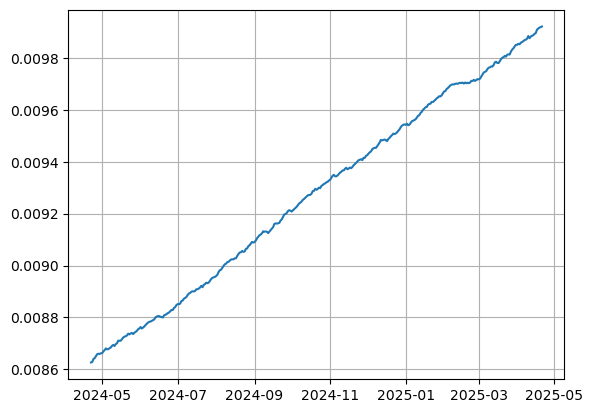

In [167]:
print("Apple")
precios_cierre_aapl=sim_R_aapl.cumprod()*0.008627
mean_aapl = precios_cierre_aapl.mean(axis=1)
plt.plot(mean_aapl)
plt.grid()


Walmart


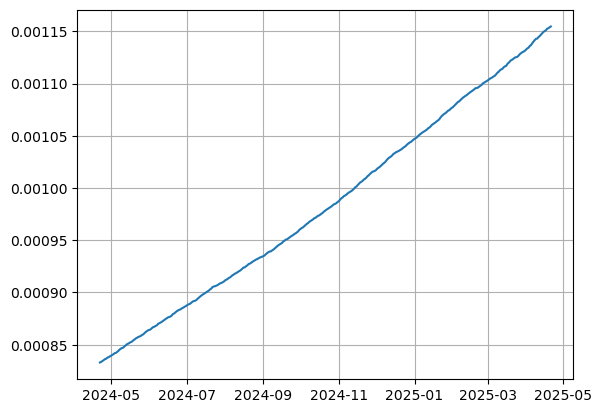

In [165]:
print("Walmart")
precios_cierre_wmt=sim_R_wmt.cumprod()*0.000832
mean_wmt = precios_cierre_wmt.mean(axis=1)
plt.plot(mean_wmt)
plt.grid()



AutoZone


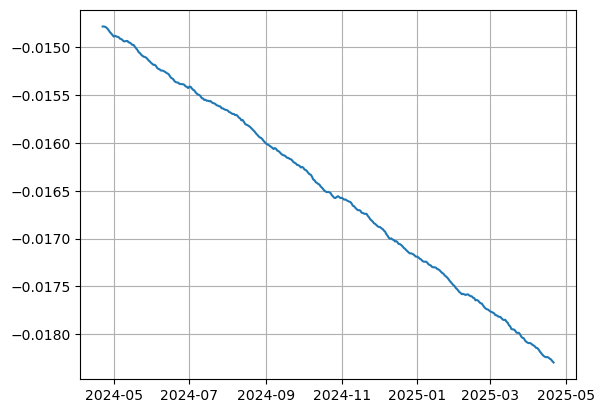

In [162]:
print("AutoZone")
precios_cierre_azo=sim_R_azo.cumprod()*-0.014780
mean_azo = precios_cierre_azo.mean(axis=1)
plt.plot(mean_azo)
plt.grid()

Occidental Petroleum


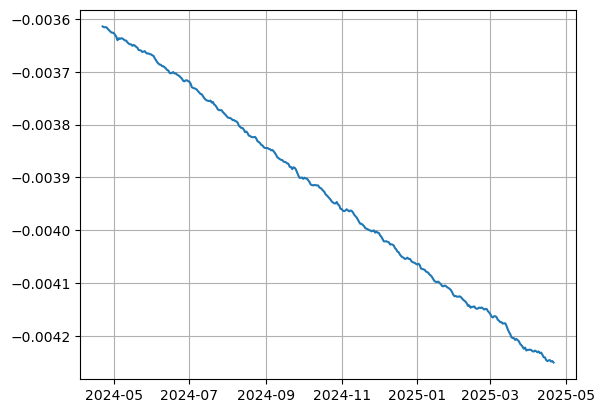

In [164]:
print("Occidental Petroleum")
precios_cierre_oxy=sim_R_oxy.cumprod()*-0.003610
mean_oxy = precios_cierre_oxy.mean(axis=1)
plt.plot(mean_oxy)
plt.grid()

Ertex Pharmaceutics


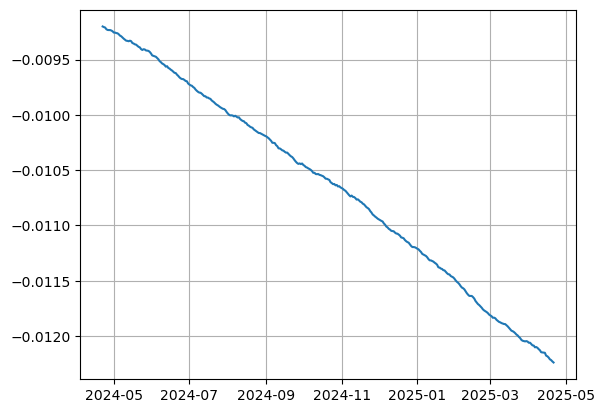

In [160]:
print("Ertex Pharmaceutics")
precios_cierre_wmt=sim_R_vrtx.cumprod()*-0.009195
mean_vrtx = precios_cierre_wmt.mean(axis=1)
plt.plot(mean_vrtx)
plt.grid()

**PROBABILIDAD DE AUMENTO DEL 20% EN EL SIGUIENTE AÑO**

In [173]:
# Probabilidad que el dinero crezca un 20%

prob_aapl = ((sim_R_aapl.cumprod()*0.008627*1.20 > 0.008627).mean(axis=1)).mean()*100
prob_wmt = ((sim_R_wmt.cumprod()*0.000832*1.20 > 0.000832).mean(axis=1)).mean()*100
prob_oxy = ((sim_R_oxy.cumprod()*-0.003610*1.20 > -0.003610).mean(axis=1)).mean()*100
prob_azo = ((sim_R_azo.cumprod()*-0.014780*1.20 > -0.014780).mean(axis=1)).mean()*100
prob_vrtx = ((sim_R_vrtx.cumprod()*-0.009195*1.20 > -0.009195).mean(axis=1)).mean()*100

print("APPLE:",prob_aapl,"%")
print("WALMART:",prob_wmt,"%")
print("AUTOZONE:",prob_azo,"%")
print("OCCIDENTAL PETROLEUM:",prob_oxy,"%")
print("ERTEX PHARMACEUTICS:",prob_vrtx,"%")


APPLE: 94.00246575342467 %
WALMART: 99.62547945205479 %
AUTOZONE: 5.776438356164382 %
OCCIDENTAL PETROLEUM: 8.865205479452055 %
ERTEX PHARMACEUTICS: 6.110684931506849 %


### Conclusiones.



### Referencias.

